In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.express as px
import plotly.graph_objects as go



In [2]:
df = pd.read_excel("Online Retail.xlsx")

In [3]:
df.shape

(541909, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Since I am focusing on customer data, drop I will drop all NaN in CustomerID.

In [7]:
# Drop missing value
df_cleaned = df.dropna(subset=['CustomerID'])

# Fill NaN with empty string
df_cleaned['Description'] = df_cleaned['Description'].fillna(' ')
df_cleaned.shape

/var/folders/x_/08j42z3j22377xv4cbjvxw880000gn/T/ipykernel_33740/3803321585.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Description'] = df_cleaned['Description'].fillna(' ')


(406829, 8)

In [8]:
df_cleaned.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,406829.000000,406829,406829.000000,406829.000000
mean,12.061303,2011-07-10 16:30:57.879207424,3.460471,15287.690570
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13953.000000
50%,5.000000,2011-07-31 11:48:00,1.950000,15152.000000
75%,12.000000,2011-10-20 13:06:00,3.750000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,248.693370,NaN,69.315162,1713.600303


In [9]:
df_cleaned['Country'].value_counts()

Country
United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45


Most of the data are from UK, Germany, France  and EIRE. So I will focus on these countries.

In [10]:
df_cleaned = df_cleaned[df_cleaned['Country'].isin(['United Kingdom', 'Germany', 
                                                    'France', 'EIRE'])]

In [11]:
df_cleaned['Country'].value_counts()

Country
United Kingdom    361878
Germany             9495
France              8491
EIRE                7485
Name: count, dtype: int64

#### Feature Engineering

In [116]:
df_cleaned['TotalSpend'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']
df_cleaned['Year'] = df_cleaned['InvoiceDate'].dt.year
df_cleaned['Month'] = df_cleaned['InvoiceDate'].dt.month
df_cleaned['Day_of_Week'] = df_cleaned['InvoiceDate'].dt.day_name()
df_cleaned['Is_weekend'] = df_cleaned['InvoiceDate'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)
df_cleaned['Time'] = df_cleaned['InvoiceDate'].dt.time
df_cleaned['Period'] = df_cleaned['InvoiceDate'].dt.strftime('%p')



In [117]:
df_cleaned.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSpend,Year,Month,Day_of_Week,Is_weekend,Time,Period
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.3,2010,12,Wednesday,0,08:26:00,AM


We can also analyze rush hours and lunchtime periods to identify when customers are most likely to purchase our products.

____

### Explore the sales

In [14]:
### Group by country and date
country_summary = df_cleaned.groupby(['Country', 'Year', 'Month']).agg({
    'Quantity': 'sum',
    'TotalSpend': 'sum',
    'InvoiceNo': 'count'
}).reset_index()

country_summary = country_summary.rename(columns={'InvoiceNo': 'Num_order_per_m', 'TotalSpend': 'Total_revenue_per_m'})
country_summary['Date'] = pd.to_datetime(country_summary['Year'].astype(str) + '-' + country_summary['Month'].astype(str))
country_summary['Date'] = country_summary['Date'] + pd.offsets.MonthEnd(1)
country_summary['Date'] = pd.to_datetime(country_summary['Date']) 
country_summary.head()

,Country,Year,Month,Quantity,Total_revenue_per_m,Num_order_per_m,Date
0,EIRE,2010,12,4858,7825.57,362,2010-12-31
1,EIRE,2011,1,8692,21671.52,188,2011-01-31
2,EIRE,2011,2,4289,7551.92,354,2011-02-28
3,EIRE,2011,3,9240,18270.28,537,2011-03-31
4,EIRE,2011,4,4135,7570.50,306,2011-04-30


In [15]:
all_countries = country_summary['Country'].unique()
fig = go.Figure()

# Calculate new tick values and labels
unique_dates = country_summary['Date'].unique()
shifted_dates = pd.to_datetime(unique_dates) + pd.DateOffset(months=1)
shifted_labels = [date.strftime('%b %Y') for date in shifted_dates]

# Define country_buttons as described above
country_buttons = [
    dict(label='All Countries',
         method='update',
         args=[{'visible': [True] * len(all_countries) * 2}]
    )
]
for i, country in enumerate(all_countries):
    visibility = [False] * len(all_countries) * 2
    visibility[i*2] = True
    visibility[i*2+1] = True
    country_buttons.append(
        dict(label=country,
             method='update',
             args=[{'visible': visibility}]
        )
    )

# Add bar and line traces for each country
for country in all_countries:
    country_data = country_summary[country_summary['Country'] == country]
    plotting_dates = country_data['Date'] + pd.DateOffset(months=1)
    
    fig.add_trace(go.Bar(
        x=plotting_dates,
        y=country_data['Num_order_per_m'],
        name=f'Orders - {country}',
        marker_color='Crimson',
        yaxis='y1',
    ))
    
    fig.add_trace(go.Scatter(
        x=plotting_dates,
        y=country_data['Total_revenue_per_m'],
        name=f'Revenue - {country}',
        mode='lines',
        line=dict(color='Gold'),
        yaxis='y2',
    ))

fig.update_layout(
    title='Monthly Total Revenue and Number of Orders by Country',
    xaxis=dict(
        title='Date',
        tickvals=shifted_dates,
        ticktext=shifted_labels,
    ),
    yaxis=dict(
        title='Number of Orders',
        titlefont=dict(color='Crimson'),
        tickfont=dict(color='Crimson'),
    ),
    yaxis2=dict(
        title='Total Revenue',
        titlefont=dict(color='Gold'),
        tickfont=dict(color='Gold'),
        overlaying='y',
        side='right',
    ),
    barmode='group',
    updatemenus=[{
        'buttons': country_buttons,
        'direction': 'down',
        'pad': {'r': 10, 't': 10},
        'showactive': True,
        'x': 0.1,
        'xanchor': 'left',
        'y': 1.15,
        'yanchor': 'top'
    }]
)

fig.show()

____

### Country_weekend_analysis

In [17]:
# Country_weekend_analysis
country_weekend_analysis = df_cleaned.groupby(['Country']).agg({
    'Is_weekend': 'sum',  
    'InvoiceNo': 'count'  
}).rename(columns={'InvoiceNo': 'Total_Purchases'})

country_weekend_analysis['Weekday_Purchases'] = country_weekend_analysis['Total_Purchases'] - country_weekend_analysis['Is_weekend']
country_weekend_analysis['Weekend_Purchase_Rate'] = country_weekend_analysis['Is_weekend'] / country_weekend_analysis['Total_Purchases']
country_weekend_analysis.reset_index(inplace=True)
country_weekend_analysis

,Country,Is_weekend,Total_Purchases,Weekday_Purchases,Weekend_Purchase_Rate
0,EIRE,464,7485,7021,0.061991
1,France,649,8491,7842,0.076434
2,Germany,797,9495,8698,0.083939
3,United Kingdom,60103,361878,301775,0.166086


In [18]:
countries = country_weekend_analysis['Country'].tolist()

initial_country = countries[0]
fig = go.Figure()

# Function to create pie chart
def create_pie_chart(country):
    country_data = country_weekend_analysis[country_weekend_analysis['Country'] == country].iloc[0]  # Adjusted to filter by country
    labels = ['Weekend Purchases', 'Weekday Purchases']
    values = [
        country_data['Is_weekend'],
        country_data['Weekday_Purchases']
    ]
    return go.Pie(labels=labels, values=values, name="")

# Add trace for the initial country
fig.add_trace(create_pie_chart(initial_country))

# Update layout to add dropdown
fig.update_layout(
    title=f"Purchases in {initial_country}",
    updatemenus=[
        dict(
            buttons=[
                dict(label=country,
                     method='restyle',
                     args=[{
                         'values': [
                             [
                                country_weekend_analysis[country_weekend_analysis['Country'] == country].iloc[0]['Is_weekend'],
                                country_weekend_analysis[country_weekend_analysis['Country'] == country].iloc[0]['Weekday_Purchases']
                             ]
                         ],
                         'labels': [['Weekend Purchases', 'Weekday Purchases']]
                     }])
                for country in countries
            ],
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.15,
            yanchor="top"
        ),
    ]
)

fig.show()

____

### Customer Spending

/var/folders/x_/08j42z3j22377xv4cbjvxw880000gn/T/ipykernel_33740/401126240.py:18: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



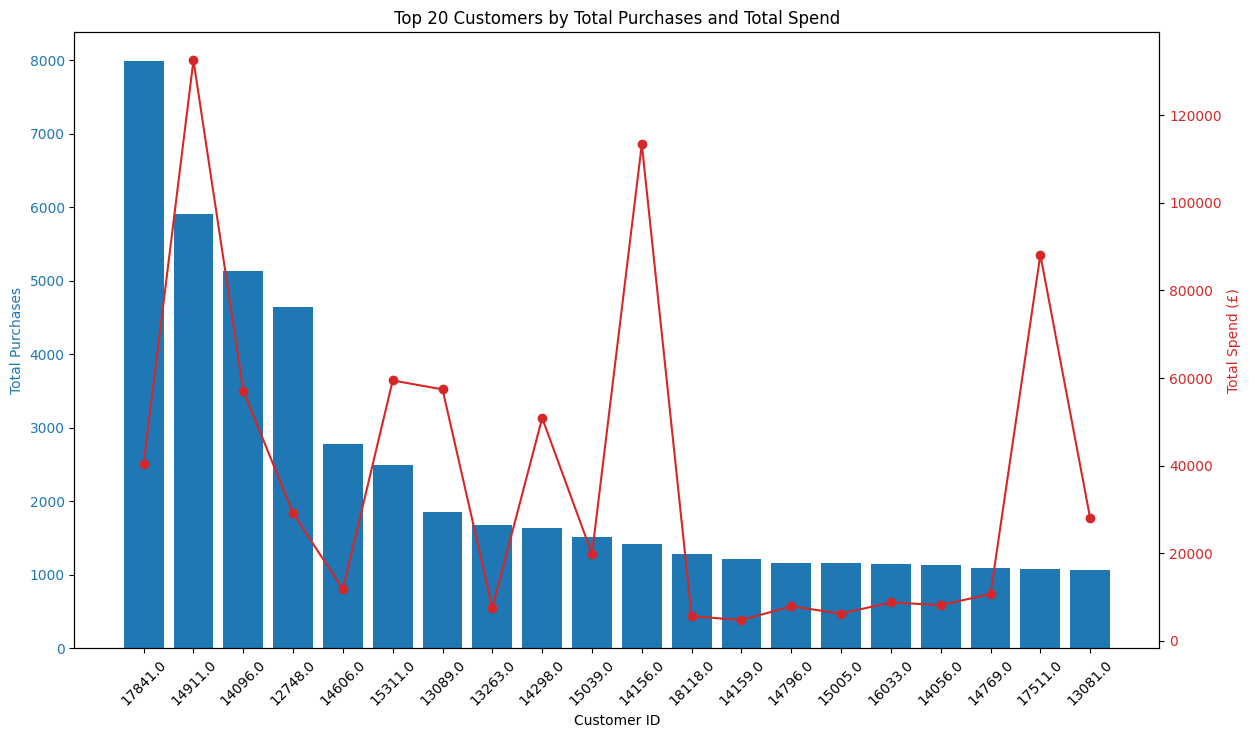

In [19]:
# Group by 'CustomerID' and calculate total purchases and total spend
customer_summary = df_cleaned.groupby('CustomerID').agg(
    Total_Purchases=pd.NamedAgg(column='InvoiceNo', aggfunc='size'),
    Total_Spend=pd.NamedAgg(column='TotalSpend', aggfunc='sum')
).reset_index()

top_customers = customer_summary.sort_values(by='Total_Purchases', ascending=False).head(20)

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar chart for Total Purchases
color = 'tab:blue'
ax1.set_xlabel('Customer ID')
ax1.set_ylabel('Total Purchases', color=color)
ax1.bar(top_customers['CustomerID'].astype(str), top_customers['Total_Purchases'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(top_customers['CustomerID'].astype(str), rotation=45)

# Create a twin axis for the total spend
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Total Spend (£)', color=color)
ax2.plot(top_customers['CustomerID'].astype(str), top_customers['Total_Spend'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.title('Top 20 Customers by Total Purchases and Total Spend')
plt.show()

/var/folders/x_/08j42z3j22377xv4cbjvxw880000gn/T/ipykernel_33740/85810742.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



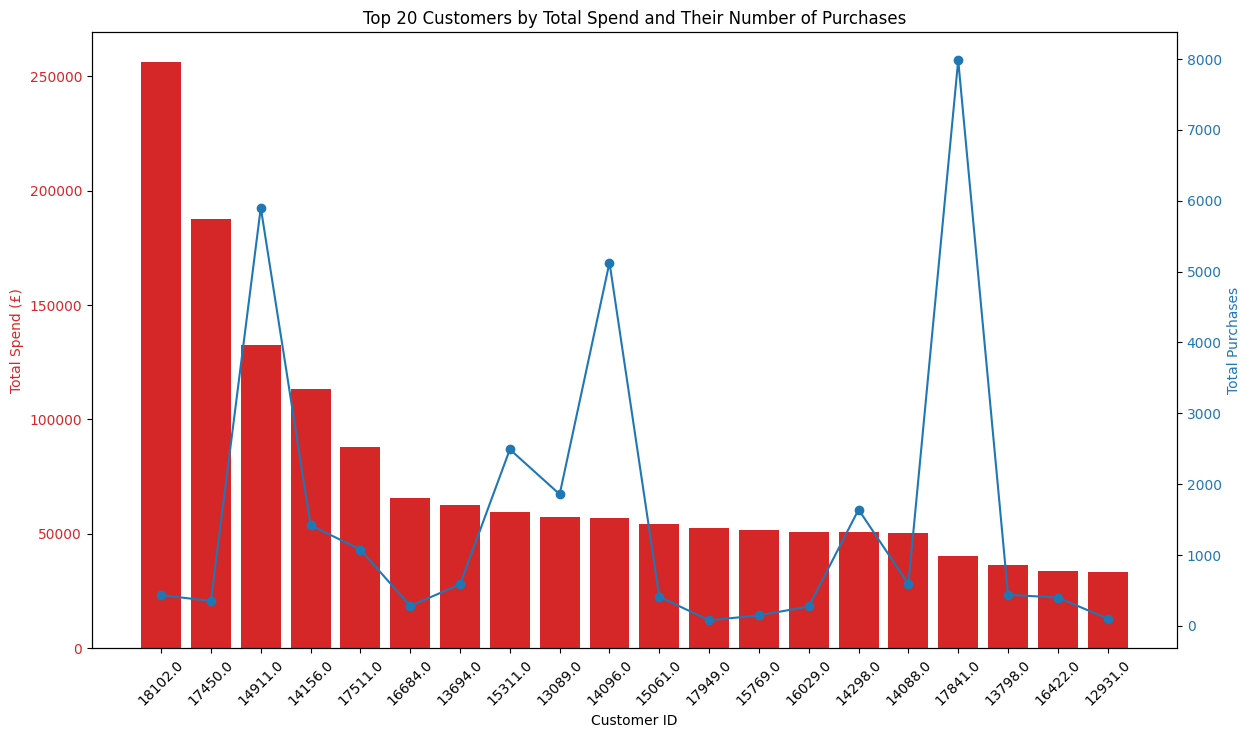

In [20]:
top_spenders = customer_summary.sort_values(by='Total_Spend', ascending=False).head(20)

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar chart for Total Spend
color = 'tab:red'
ax1.set_xlabel('Customer ID')
ax1.set_ylabel('Total Spend (£)', color=color)
ax1.bar(top_spenders['CustomerID'].astype(str), top_spenders['Total_Spend'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(top_spenders['CustomerID'].astype(str), rotation=45)

# Create a twin axis for the number of purchases
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Total Purchases', color=color)
ax2.plot(top_spenders['CustomerID'].astype(str), top_spenders['Total_Purchases'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.title('Top 20 Customers by Total Spend and Their Number of Purchases')
plt.show()

Customer Behavior Diversity: There is significant variability in how customers interact with the business. Some make many small purchases, while others make fewer, much larger purchases.

Targeted Marketing Potential: Understanding these patterns can help tailor marketing and sales strategies. For example, customers with high total spends but fewer purchases might be targeted with promotions on high-value products.

Customer Value Insight: These visualizations highlight which customers are most valuable in terms of revenue generation, which can influence loyalty programs and retention strategies.

___

### Daily Sales in each countries

In [21]:
daily_sales = df_cleaned.groupby([df_cleaned['Country'], df_cleaned['InvoiceDate'].dt.date]).agg(DailySales=('TotalSpend', 'sum')).reset_index()

Dropdown(description='Country:', index=4, options=('All', 'EIRE', 'France', 'Germany', 'United Kingdom'), valu…

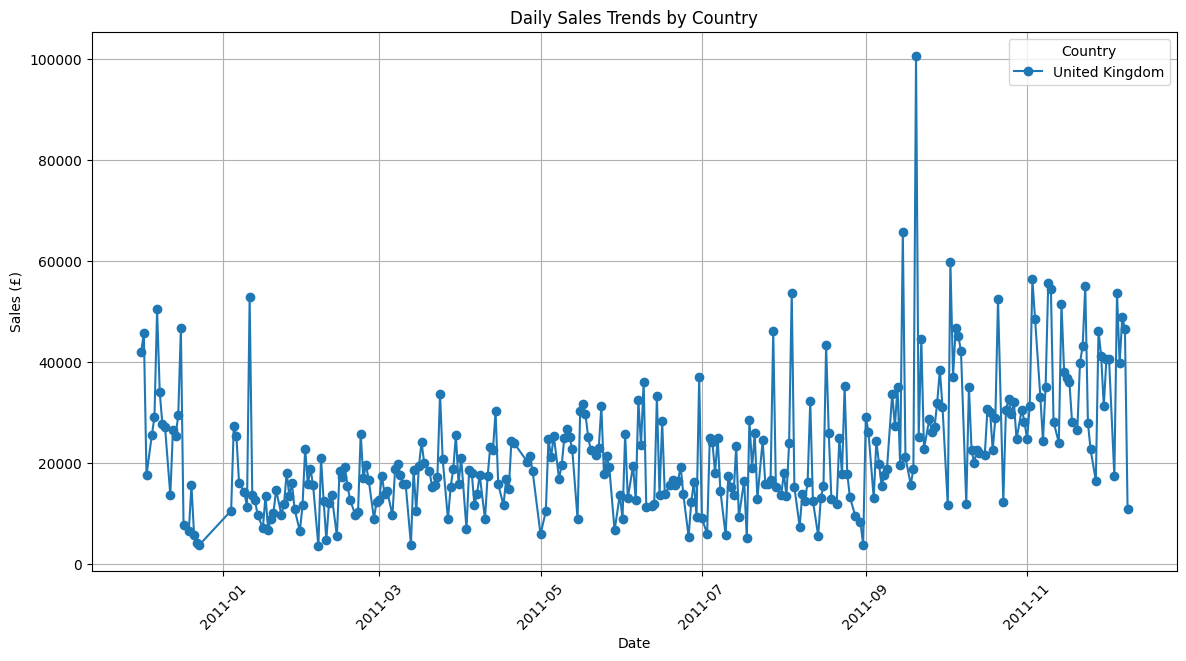

In [22]:
# Create a dropdown for country selection
country_dropdown = widgets.Dropdown(
    options = ['All'] + list(daily_sales['Country'].unique()),
    value='All',
    description='Country:',
    disabled=False,
)

def plot_filtered_sales(change):
    # Clear current output
    clear_output(wait=True)
    display(country_dropdown)  
    
    # Filter the data based on the dropdown
    if change.new == 'All':
        filtered_data = daily_sales
    else:
        filtered_data = daily_sales[daily_sales['Country'] == change.new]
    
    # Plotting
    plt.figure(figsize=(14, 7))
    for country in filtered_data['Country'].unique():
        country_data = filtered_data[filtered_data['Country'] == country]
        plt.plot(country_data['InvoiceDate'], country_data['DailySales'], marker='o', label=country)
    
    plt.title('Daily Sales Trends by Country')
    plt.xlabel('Date')
    plt.ylabel('Sales (£)')
    plt.xticks(rotation=45)
    plt.legend(title='Country')
    plt.grid(True)
    plt.show()

# Display the dropdown
display(country_dropdown)

# Call the plotting function when the dropdown value changes
country_dropdown.observe(plot_filtered_sales, names='value')



Volatility and Peaks: The sales data shows significant variability, with occasional peaks that suggest large transactions or high sales volume days. Identifying what causes these spikes—whether seasonal trends, marketing campaigns, or specific events—could provide valuable insights for planning and optimization.

Seasonal Patterns: While the chart covers a full year, a closer examination could reveal if there are certain times of the year (like holidays or specific months) where sales consistently peak. This could help in forecasting demand and managing inventory more effectively.

Data Distribution: The distribution of sales is skewed, with many days showing relatively lower sales and a few days with exceptionally high sales. This skewness might indicate that most days have moderate sales activity, but a small number of days (perhaps due to promotions or special events) drive a large volume of sales.

___

### Explore the products

In [33]:
print('We have', df_cleaned['Description'].nunique(), 'unique products')

We have 3888 unique products


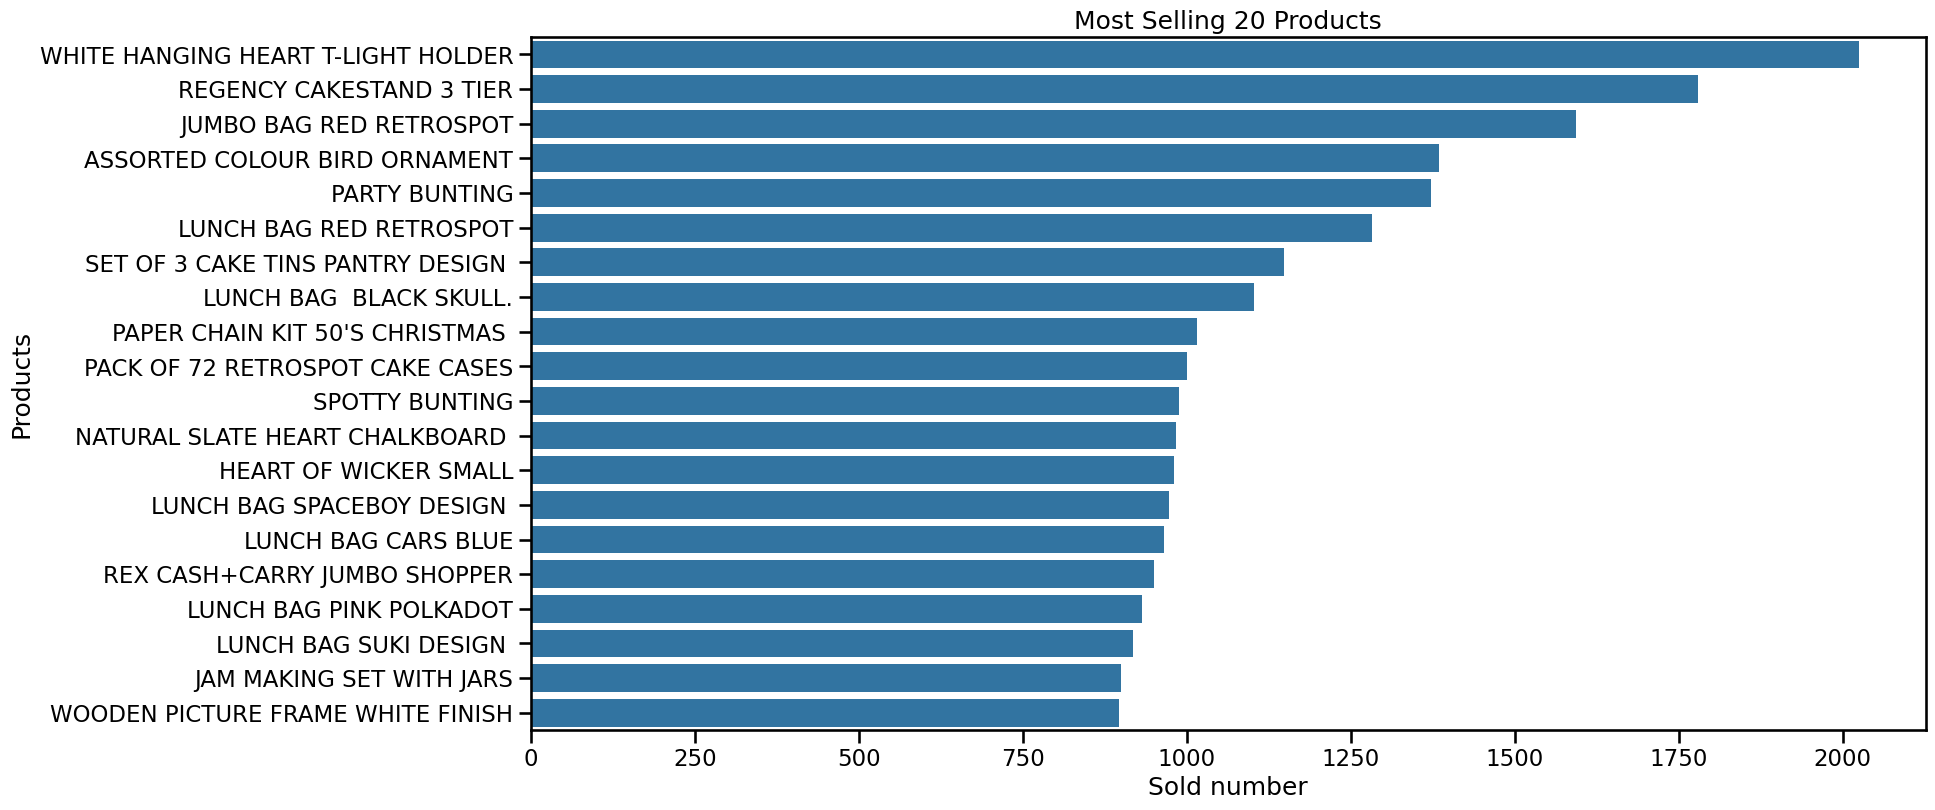

In [130]:
most_selling_products = df_cleaned['Description'].value_counts()[:20]
plt.figure(figsize = (18,9))
sns.set_context("talk")
sns.barplot(x = most_selling_products.values, y = most_selling_products.index)
plt.xlabel("Sold number")
plt.ylabel("Products")
plt.title("Most Selling 20 Products")

plt.show()

______


### Generate category with AI

##### Use chatgpt

In [86]:
from openai import OpenAI
import time

In [109]:
test = df_cleaned.sample(30)

In [ ]:
client = OpenAI(
    api_key=os.environ.get("Key"),
)

def generate_product_category(description):
    try:
        # Define the system and user messages for ChatGPT
        messages = [
            {"role": "system", "content": "You are a helpful assistant that generates concise and suitable category name. The name should not be narrow."},
            {"role": "user", "content": f"Create a concise product category for the following product description:\n\n'{description}'"}
        ]

        # Call the OpenAI API using the ChatCompletion endpoint
        response = client.chat.completions.create(
            model="gpt-3.5-turbo-4",  
            messages=messages,
            temperature=0.7,  
            max_tokens=8 
        )
        
        # Extract the generated product name from the response
        product_category = response['choices'][0]['message']['content'].strip()
        return product_category

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

test['Product_category'] = test['Description'].apply(generate_product_category)

print(test)

I didn't generate with OpenAI because it requires to pay. So I will try Greq to with llama3.

In [89]:
import os
from groq import Groq

In [126]:
test = df_cleaned.sample(20)

In [127]:
GROQ_API_KEY = "KEY"
os.environ["GROQ_API_KEY"] = GROQ_API_KEY

# Initialize the Groq client
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

class Agent:
    def __init__(self, role, goal, backstory):
        self.role = role
        self.goal = goal
        self.backstory = backstory
        self.client = client

    def call_groq(self, prompt):
        chat_completion = self.client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model="llama3-8b-8192",
        )
        return chat_completion.choices[0].message.content.strip()

    def on_message(self, message, context):
        prompt = f"{context}\n\n{message}"
        return self.call_groq(prompt)
    
class MarketingAssistant(Agent):
    def __init__(self):
        super().__init__(
            role="Marketing assistant",
            goal="Assist users to generates concise and suitable category names based on the description. The name should not be narrow.",
            backstory="You have 10 years of experience generating category names for companies."
        )
    
    def generate_category(self, description):
        prompt = f"Based on this product description, '{description}', generate a concise and appropriate category name. Only return the category name. For example, KNITTED UNION FLAG HOT WATER BOTTLE return Home & Living Essentials. All types of toys, playhouse or anything relate to toys return Toys."
        return self.call_groq(prompt)

if __name__ == "__main__":
    # Initialize the assistant
    assistant = MarketingAssistant()

    # Generate product categories for each description and store them in the DataFrame
    test['Product_category'] = test['Description'].apply(assistant.generate_category)

    


In [128]:
test

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSpend,Year,Month,Day_of_Week,Is_weekend,Time,Period,Product_category
167039,550968,22993,SET OF 4 PANTRY JELLY MOULDS,12,2011-04-21 16:59:00,1.25,14961.0,United Kingdom,15.00,2011,4,Thursday,0,16:59:00,PM,Home & Kitchen
49295,540511,84879,ASSORTED COLOUR BIRD ORNAMENT,8,2011-01-09 11:34:00,1.69,14472.0,United Kingdom,13.52,2011,1,Sunday,1,11:34:00,AM,Home Decor
485830,577690,23369,SET 36 COLOUR PENCILS LOVE LONDON,2,2011-11-21 11:34:00,1.25,12856.0,United Kingdom,2.50,2011,11,Monday,0,11:34:00,AM,Arts & Crafts
452052,575318,23349,ROLL WRAP VINTAGE CHRISTMAS,12,2011-11-09 13:17:00,1.25,14921.0,United Kingdom,15.00,2011,11,Wednesday,0,13:17:00,PM,Home & Living Decor
228013,556914,15044D,RED PAPER PARASOL,9,2011-06-15 13:34:00,2.95,12877.0,United Kingdom,26.55,2011,6,Wednesday,0,13:34:00,PM,Branded Accessories
179912,552291,22433,WATERING CAN GREEN DINOSAUR,6,2011-05-08 14:00:00,1.95,15421.0,United Kingdom,11.70,2011,5,Sunday,1,14:00:00,PM,Toys
221660,556263,23205,CHARLOTTE BAG VINTAGE ALPHABET,6,2011-06-09 18:41:00,0.85,13969.0,United Kingdom,5.10,2011,6,Thursday,0,18:41:00,PM,Home & Living Accessories
108933,545571,85152,HAND OVER THE CHOCOLATE SIGN,12,2011-03-03 16:34:00,2.10,17700.0,United Kingdom,25.20,2011,3,Thursday,0,16:34:00,PM,Toys
265179,560209,22948,METAL DECORATION NAUGHTY CHILDREN,2,2011-07-15 14:05:00,0.85,15004.0,United Kingdom,1.70,2011,7,Friday,0,14:05:00,PM,Toys & Novelties
389601,570482,23318,BOX OF 6 MINI VINTAGE CRACKERS,2,2011-10-10 17:00:00,2.49,17459.0,United Kingdom,4.98,2011,10,Monday,0,17:00:00,PM,Food & Beverages


I tested with the code, and it can generate the value quite well. Unfortunately, 400k prompts generation requires me to pay again. So I will stop it here. 

In [41]:
df_cleaned.to_csv('cleaned_Online_Retail.csv')